# Model Intercomparison

In [5]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
from pathlib import Path
result_files = sorted(list(Path().glob("results_*.nc")))
drop = ["rel_err_dist", "rel_err_dist_cs", "rel_err_dist_ic", "err_dist", "err_dist_cs", "err_dist_ic", "rel_err_bin", "err_bin"]
all_results = xr.concat([xr.load_dataset(path) for path in result_files], dim="version").sortby("version") 
results = xr.concat([xr.load_dataset(path).drop_vars(drop, errors="ignore") for path in result_files], dim="version").sortby("version")

/home/simon/miniforge3/envs/hrem/lib/python3.11/site-packages/xarray/structure/concat.py:637: UserWarning: No index created for dimension version because variable version is not a coordinate. To create an index for version, please first call `.set_coords('version')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)
/home/simon/miniforge3/envs/hrem/lib/python3.11/site-packages/xarray/structure/concat.py:637: UserWarning: No index created for dimension version because variable version is not a coordinate. To create an index for version, please first call `.set_coords('version')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


# Relative Error Distributions
## Clearsky

Text(0.5, 0.94, 'Relative Errors (Clearksy)')

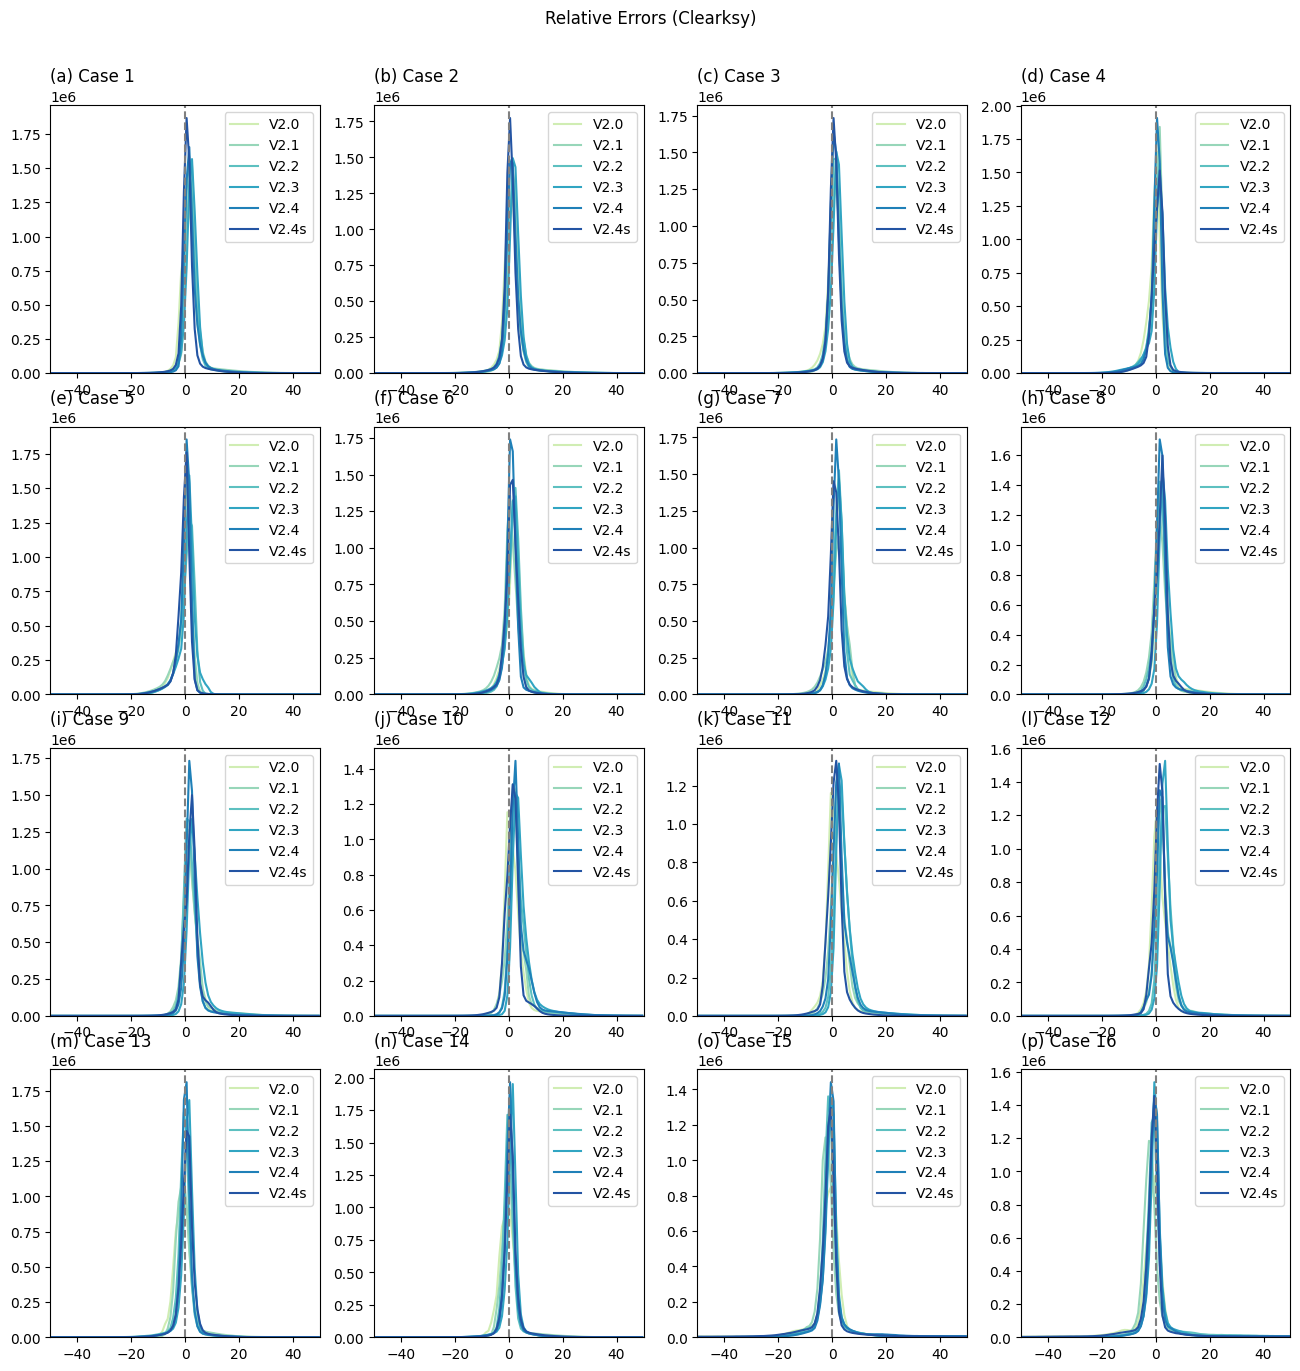

In [7]:
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

fig, axs = plt.subplots(4, 4, figsize=(16, 16))
mappable = ScalarMappable(cmap="YlGnBu", norm=Normalize(-2, 7))
for ind in range(16):
    row = ind // 4
    col = ind % 4
    for ver in range(results.version.size):
        version = results.version[ver].data
        axs[row, col].plot(all_results.rel_err_bin, all_results[{"version": ver}].rel_err_dist_cs[ind], label=version, c=mappable.to_rgba(ver))
    axs[row, col].axvline(x=0, ls="--", c="grey")
    axs[row, col].set_ylim(0, None)
    axs[row, col].set_xlim(-50, 50)
    axs[row, col].set_title(f"({chr(ord('a') + ind)}) Case {ind + 1}", loc="left")
    axs[row, col].legend()
fig.suptitle("Relative Errors (Clearksy)", y=0.94)

## Cloudy Sky

Text(0.5, 0.94, 'Relative Errors (Cloudy)')

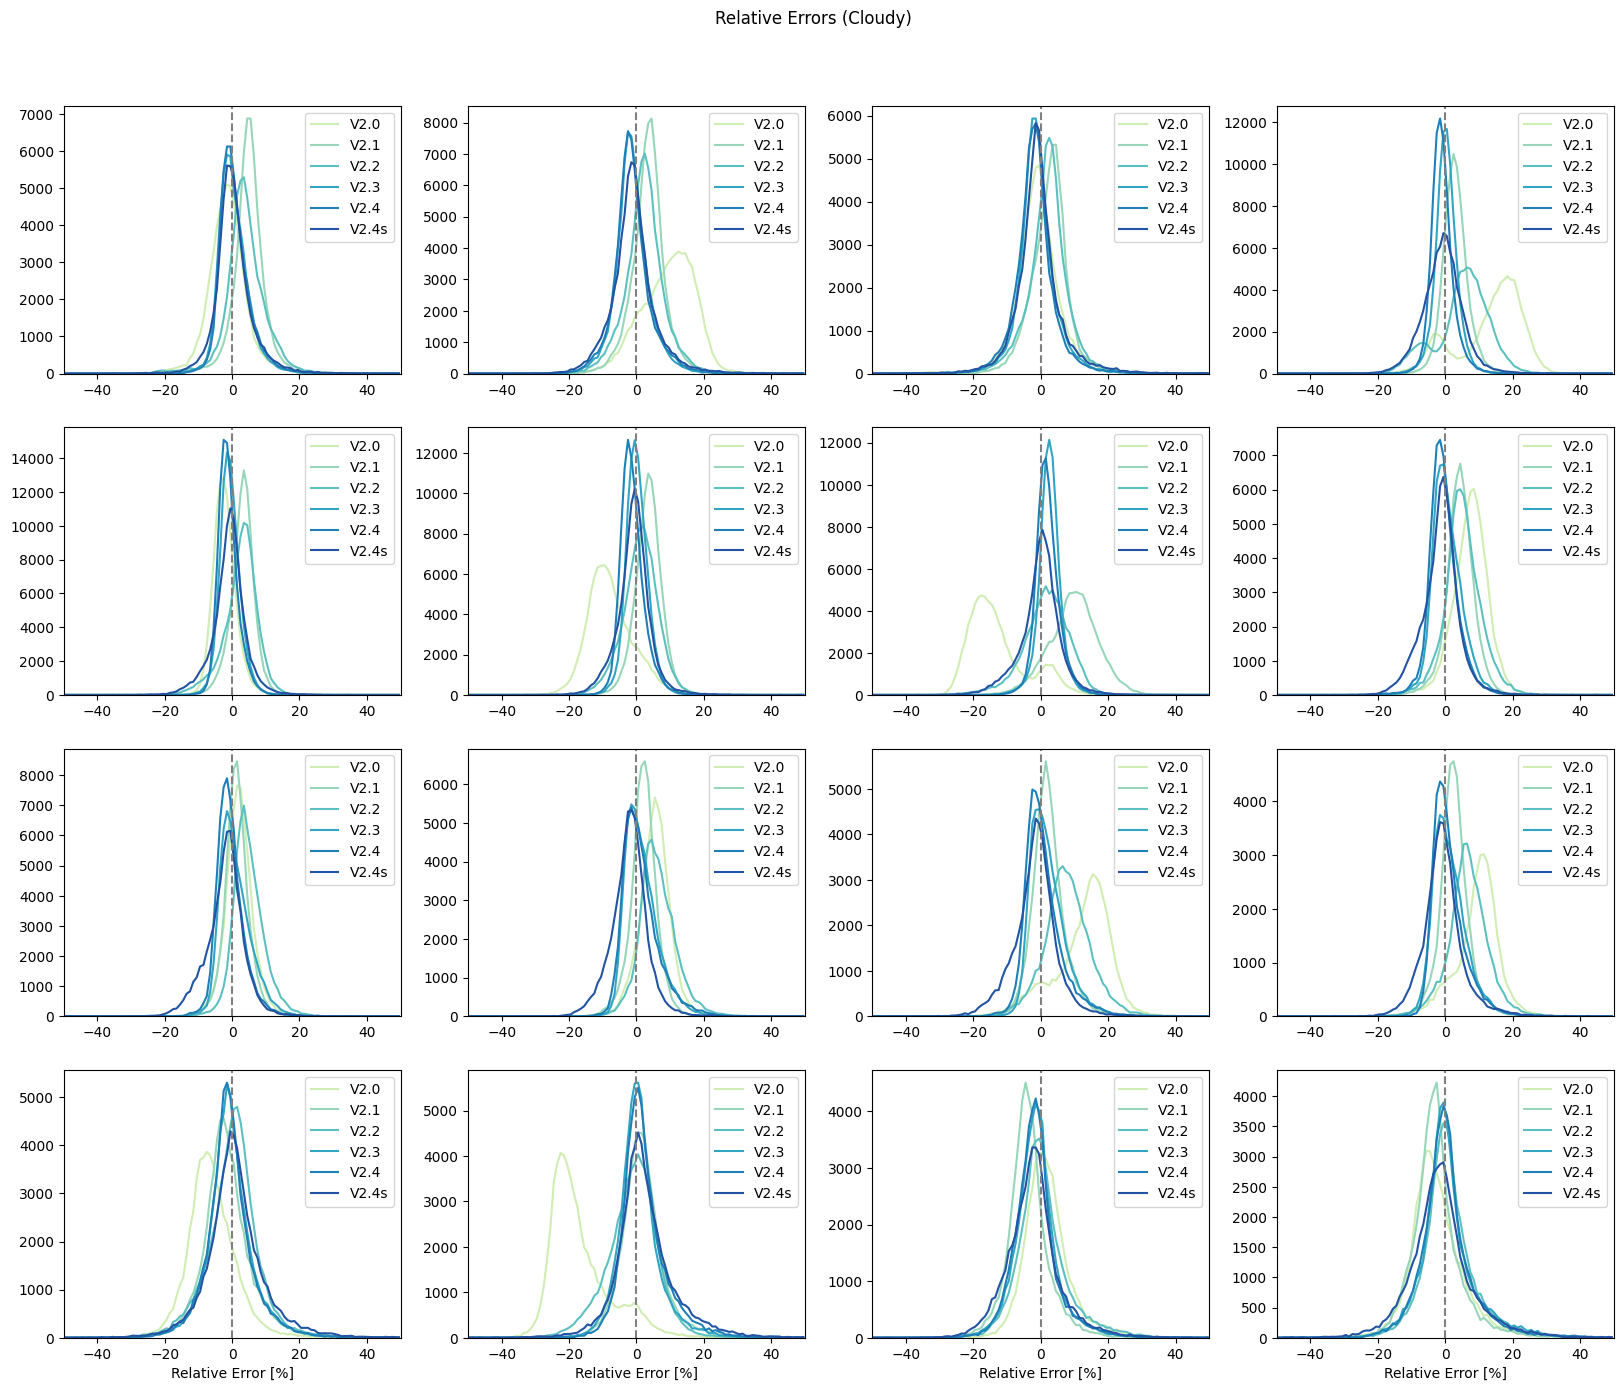

In [8]:
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

fig, axs = plt.subplots(4, 4, figsize=(20, 16))
mappable = ScalarMappable(cmap="YlGnBu", norm=Normalize(-2, 7))
for ind in range(16):
    row = ind // 4
    col = ind % 4
    for ver in range(results.version.size):
        version = results.version[ver].data
        axs[row, col].plot(all_results.rel_err_bin, all_results[{"version": ver}].rel_err_dist_ic[ind], label=version, c=mappable.to_rgba(ver))
    axs[row, col].axvline(x=0, ls="--", c="grey")
    axs[row, col].set_ylim(0, None)
    axs[row, col].set_xlim(-50, 50)
    axs[row, col].legend()
    if row == 3:
        axs[row, col].set_xlabel("Relative Error [%]")
fig.suptitle("Relative Errors (Cloudy)", y=0.94)

## Error Metrics

In [9]:
for suffix in ["", "_cs", "_ic"]:
    for err in ["rel_err", "rel_abs_err"]:
        results[err + suffix] = 100.0 * results[err + suffix]
        
for suffix in ["", "_cs", "_ic"]:
    for err in ["squared_err"]:
        results["rmse" + suffix] = np.sqrt(results[err + suffix])

In [10]:
results = results.to_dataframe().reset_index().melt(
    id_vars="version",
    var_name='metric',         # New column name for former column names
    value_name='value'         # New column name for values
)

Bad value in file 'style.mplstyle', line 85 ("axes.prop_cycle      : cycler('color', ['#000000', '#E69F00', '#56B4E9', '#009E73', '#F0E442', '#0072B2', '#D55E00', '#CC79A7'])"): Key axes.prop_cycle: "cycler('color', ['" is not a valid cycler construction: unterminated string literal (detected at line 1) (<unknown>, line 1)
/tmp/ipykernel_808447/3963633143.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(res_bias, x="version", y="value", palette=palette)
/tmp/ipykernel_808447/3963633143.py:11: UserWarning: The palette list has more values (48) than needed (6), which may not be intended.
  sns.barplot(res_bias, x="version", y="value", palette=palette)
/tmp/ipykernel_808447/3963633143.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `

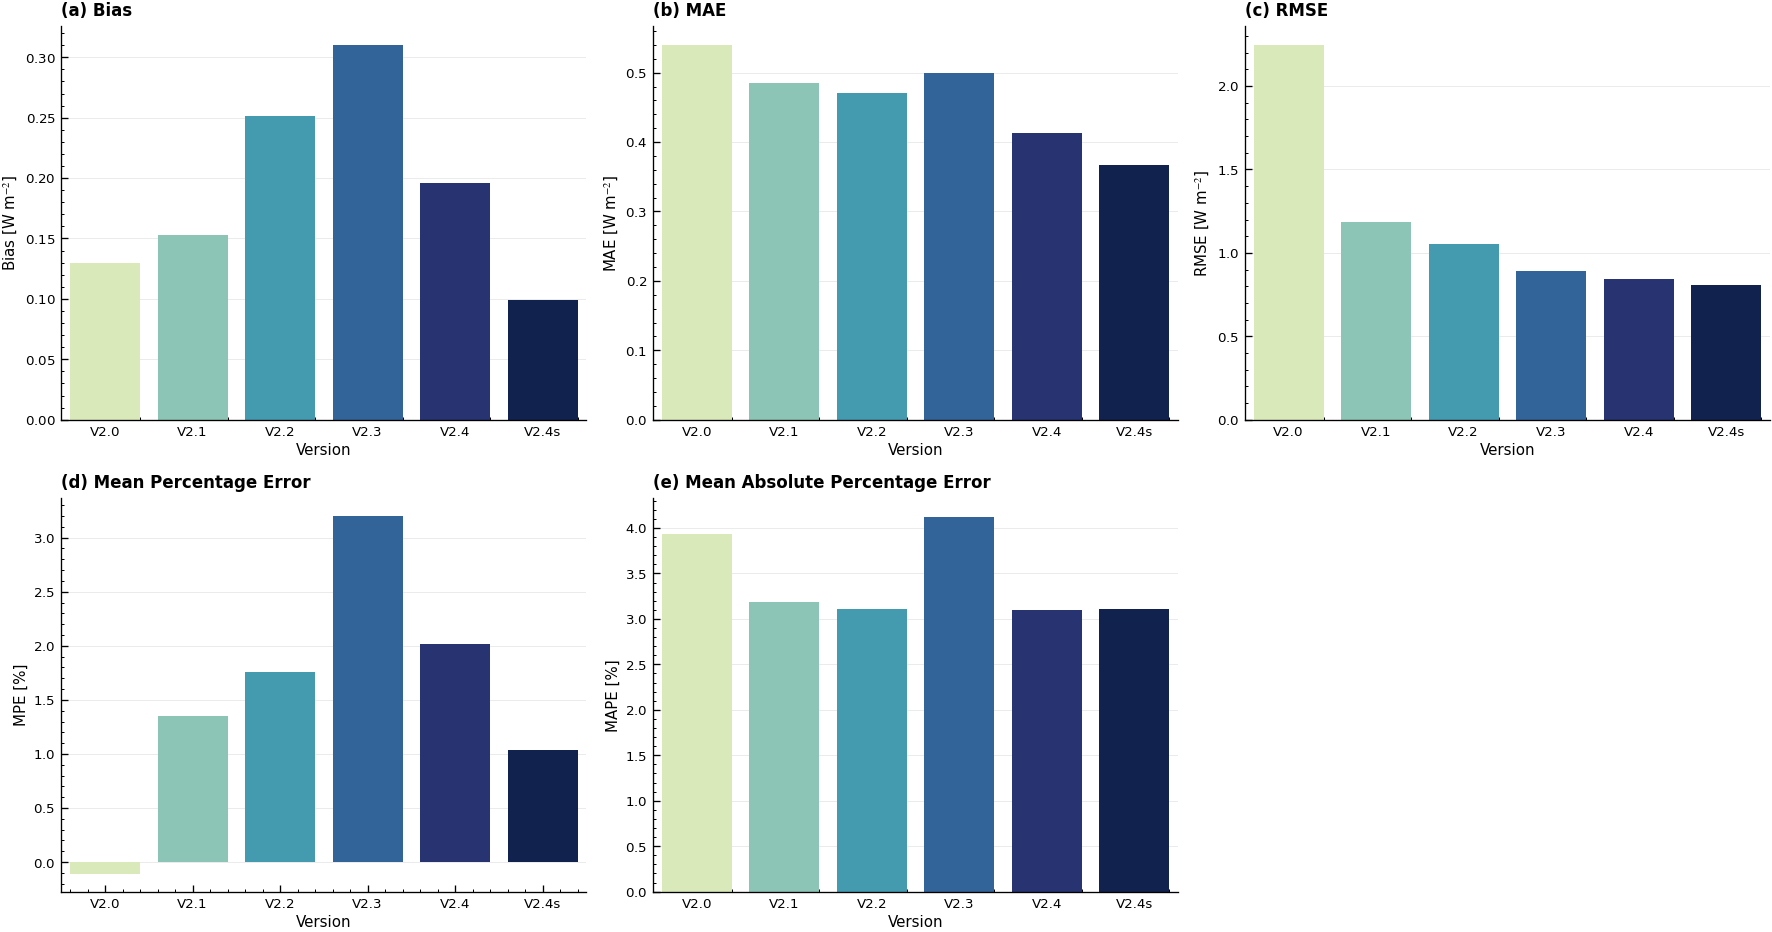

In [11]:
import seaborn as sns
from matplotlib.gridspec import GridSpec
plt.style.use("style.mplstyle")
fig = plt.figure(figsize=(15, 8))
gs = GridSpec(2, 3)
cmap = plt.get_cmap("YlGnBu")
palette = [cmap(val) for val in np.linspace(0, 9)[1:-1]]

ax = fig.add_subplot(gs[0, 0])
res_bias = results.loc[results.metric == "bias"]
sns.barplot(res_bias, x="version", y="value", palette=palette)
ax.set_ylabel("Bias [W m$^{-2}$]")
ax.set_title("(a) Bias", loc="left")
ax.set_xlabel("Version")

ax = fig.add_subplot(gs[0, 1])
res_abs_err = results.loc[results.metric == "abs_err"]
sns.barplot(res_abs_err, x="version", y="value", palette=palette)
ax.set_ylabel("MAE [W m$^{-2}$]")
ax.set_title("(b) MAE", loc="left")
ax.set_xlabel("Version")

ax = fig.add_subplot(gs[0, 2])
res_squared_err = results.loc[results.metric == "rmse"]
sns.barplot(res_squared_err, x="version", y="value", palette=palette)
ax.set_ylabel("RMSE [W m$^{-2}$]")
ax.set_title("(c) RMSE", loc="left")
ax.set_xlabel("Version")

ax = fig.add_subplot(gs[1, 0])
res_squared_err = results.loc[results.metric == "rel_err"]
sns.barplot(res_squared_err, x="version", y="value", palette=palette)
ax.set_title("(d) Mean Percentage Error", loc="left")
ax.set_ylabel("MPE [%]")
ax.set_xlabel("Version")

ax = fig.add_subplot(gs[1, 1])
res_squared_err = results.loc[results.metric == "rel_abs_err"]
ax.set_title("(e) Mean Absolute Percentage Error", loc="left")
sns.barplot(res_squared_err, x="version", y="value", palette=palette)
ax.set_ylabel("MAPE [%]")
ax.set_xlabel("Version")

plt.tight_layout()